## Campos involucrados

- escuelascercanas
- centroscomercialescercanos
- idzona

## Ideas

- Agregar info externa (transporte cercano? barrios "de moda"?)
- Caracterización de zona
  - Centro Geográfico
  - ¿diámetro?
  - Promedios
    - metroscubiertos
    - precio
    - ...
- Armar un dataframe con info de zonas?

In [1]:
#importo las funciones para levantar los dataframes
%run "../../utils/dataset_parsing.ipynb"
#importo las funciones para graficar
%run "../../utils/graphs.ipynb"
df = levantar_datos("../../"+DATASET_RELATIVE_PATH)
df.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio', 'mes', 'ano', 'dia'],
      dtype='object')

In [2]:
df["precio_metro_cubierto"] = df["precio"] / df["metroscubiertos"]
df["precio_metro_total"] = df["precio"] / df["metrostotales"]

In [3]:
promedios = df.groupby(["idzona"]).agg({"id": "count", "precio_metro_total": ["mean","std"], "precio_metro_cubierto": ["mean","std"]}).fillna(0).astype(int)
promedios.columns = ["publicaciones", "promedio_metrostotales", "desvio_metrostotales", "promedio_metroscubiertos","desvio_metroscubiertos"]
promedios.index = promedios.index.astype(int)
promedios.head()

,publicaciones,promedio_metrostotales,desvio_metrostotales,promedio_metroscubiertos,desvio_metroscubiertos
idzona,,,,,
22,15,22044,11082,24215,13060
23,26,8136,3078,6918,2533
26,10,5617,2043,6492,1341
27,1,6190,0,7222,0
28,2,6875,4419,5481,1122


In [4]:
promedios.loc[promedios.index == 74]

,publicaciones,promedio_metrostotales,desvio_metrostotales,promedio_metroscubiertos,desvio_metroscubiertos
idzona,,,,,
74,3,9250,750,7072,1625


In [5]:
# me quedo con las zonas que tengan más publicaciones y ordeno por precio 
top_100_publicaciones = promedios.sort_values(by="publicaciones", ascending=False).head(100).sort_values(by="promedio_metroscubiertos", ascending=False)
# 10 barrios más caros
top_10 = top_100_publicaciones.head(10)
# 10 barrios más baratos
last_10 = top_100_publicaciones.tail(10)

In [6]:
top_10

,publicaciones,promedio_metrostotales,desvio_metrostotales,promedio_metroscubiertos,desvio_metroscubiertos
idzona,,,,,
275358,1274,43868,17483,43322,16522
24598,227,42227,14948,43185,14550
24597,263,42195,16639,41557,16244
23771,418,39844,14354,39383,13249
23815,1023,42065,18752,38524,15330
23816,266,35473,14404,36337,14375
23191,599,36041,12998,35528,17345
275338,346,33990,12793,34855,12780
23837,510,35922,18157,33952,25158


In [7]:
last_10

,publicaciones,promedio_metrostotales,desvio_metrostotales,promedio_metroscubiertos,desvio_metroscubiertos
idzona,,,,,
113862,305,10833,19073,10963,4263
84028,610,11009,2582,10880,1975
113851,391,11282,17540,10873,2577
323499,240,17077,5135,10826,2987
87689,290,11288,5857,10601,5554
107098,362,13678,5017,10542,1853
50003433,378,9553,4236,10522,4105
114069,230,9901,34236,10368,5677
114343,270,4996,3013,8469,3467


In [8]:
df.loc[df.idzona.isin(top_10.index)].describe()

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,precio,mes,ano,dia,precio_metro_cubierto,precio_metro_total
count,5789.000000,4810.000000,5520.000000,5435.000000,5555.000000,5709.000000,3285.000000,5789.000000,3030.000000,3030.000000,5.789000e+03,5789.000000,5789.000000,5789.000000,5709.000000,3285.000000
mean,151880.738297,9.554688,2.412109,1.605469,2.066406,147.412155,147.438354,94169.666955,19.379045,-98.861441,5.365368e+06,7.420971,2014.813094,15.566246,38189.766363,39037.613817
std,86103.992606,11.703125,0.784180,0.746582,0.696777,72.945549,70.495163,112953.777071,1.055910,7.249843,2.797023e+06,3.578015,1.177989,8.872940,16738.620395,16674.661299
min,81.000000,0.000000,1.000000,0.000000,1.000000,15.000000,15.000000,23191.000000,-20.456045,-105.937718,3.300000e+05,1.000000,2012.000000,1.000000,1254.752852,1254.752852
25%,78031.000000,1.000000,2.000000,1.000000,2.000000,94.000000,95.000000,23569.000000,19.392705,-99.209414,3.200000e+06,4.000000,2014.000000,8.000000,27500.000000,28275.862069
50%,152269.000000,5.000000,2.000000,2.000000,2.000000,128.000000,130.000000,23815.000000,19.415556,-99.185938,4.833300e+06,8.000000,2015.000000,15.000000,37428.571429,38414.634146
75%,226485.000000,10.000000,3.000000,2.000000,2.000000,180.000000,181.000000,275338.000000,19.433183,-99.174283,7.000000e+06,11.000000,2016.000000,23.000000,47115.384615,47979.797980
max,299994.000000,80.000000,10.000000,3.000000,4.000000,433.000000,430.000000,275358.000000,35.680060,99.226540,1.252500e+07,12.000000,2016.000000,31.000000,509950.000000,259761.904762


In [9]:
df.loc[df.idzona.isin(last_10.index)].describe()

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,precio,mes,ano,dia,precio_metro_cubierto,precio_metro_total
count,3320.000000,2470.000000,3132.000000,2935.000000,2952.000000,3159.000000,2822.000000,3.320000e+03,1071.000000,1071.000000,3.320000e+03,3320.000000,3320.000000,3320.00000,3159.000000,2822.000000
mean,150930.344578,2.136719,2.943359,1.833984,2.546875,204.574554,206.955002,5.792566e+06,22.593682,-96.364591,2.093667e+06,7.364458,2014.549398,15.28494,10272.118487,10790.515873
std,86830.413896,4.132812,0.584961,0.696777,0.895996,85.869400,93.456879,1.584976e+07,4.092880,11.653739,1.120528e+06,3.369529,1.399425,8.90867,3661.733555,12389.679211
min,29.000000,0.000000,1.000000,0.000000,1.000000,15.000000,16.000000,2.351000e+03,0.000000,-117.118064,3.100000e+05,1.000000,2012.000000,1.00000,1666.666667,1166.666667
25%,75801.500000,0.000000,3.000000,2.000000,2.000000,150.000000,134.000000,8.402800e+04,20.655260,-100.407315,1.398750e+06,5.000000,2013.000000,8.00000,8666.666667,7166.825095
50%,151004.000000,0.000000,3.000000,2.000000,3.000000,192.000000,168.500000,1.138510e+05,21.049456,-100.345812,1.895000e+06,8.000000,2015.000000,15.00000,9963.099631,9937.500000
75%,227949.750000,3.000000,3.000000,2.000000,3.000000,262.000000,279.000000,1.143430e+05,22.160025,-89.585514,2.700000e+06,10.000000,2016.000000,23.00000,11325.827206,12799.404762
max,299883.000000,50.000000,8.000000,3.000000,4.000000,437.000000,439.000000,5.000343e+07,32.533514,0.000000,1.150000e+07,12.000000,2016.000000,31.00000,96666.666667,450000.000000


In [10]:
df.loc[df.idzona==113862].describe()

,id,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,precio,mes,ano,dia,precio_metro_cubierto,precio_metro_total
count,305.000000,220.000000,292.000000,234.000000,243.000000,295.00000,208.000000,305.0,76.000000,76.000000,3.050000e+02,305.000000,305.000000,305.000000,295.000000,208.000000
mean,154559.163934,1.695312,3.109375,2.103516,3.126953,275.08136,294.326935,113862.0,21.032868,-89.617015,2.946872e+06,7.318033,2014.278689,15.747541,10963.058030,10833.694006
std,85909.475003,4.460938,0.674805,0.710449,0.831055,83.04818,97.235954,0.0,0.003344,0.004630,1.148428e+06,3.284809,1.445628,8.908815,4263.162818,19073.157112
min,681.000000,0.000000,1.000000,0.000000,1.000000,29.00000,20.000000,113862.0,21.016730,-89.634225,1.050000e+06,1.000000,2012.000000,1.000000,6551.724138,3304.597701
25%,82091.000000,0.000000,3.000000,2.000000,3.000000,229.50000,250.000000,113862.0,21.030952,-89.619227,2.050000e+06,5.000000,2013.000000,8.000000,9142.857143,7851.208459
50%,156900.000000,0.000000,3.000000,2.000000,3.000000,287.00000,300.000000,113862.0,21.033194,-89.616618,2.850000e+06,8.000000,2014.000000,15.000000,10147.058824,8790.934844
75%,230119.000000,1.000000,3.000000,2.000000,4.000000,330.00000,350.000000,113862.0,21.035249,-89.614344,3.600000e+06,10.000000,2016.000000,23.000000,11264.822134,10000.000000
max,298788.000000,50.000000,6.000000,3.000000,4.000000,430.00000,434.000000,113862.0,21.038605,-89.607582,6.900000e+06,12.000000,2016.000000,31.000000,50000.000000,280530.000000


## Armo un Dataframe donde las filas son las zonas

In [11]:
calculations = ["mean","std","max","min"]
aggregations = {"id": "count",\
                "precio_metro_total": calculations,\
                "precio_metro_cubierto": calculations,\
                "antiguedad": calculations,\
                "habitaciones": calculations,\
                "metroscubiertos": calculations,\
                "metrostotales": calculations,\
                "lat": calculations,\
                "lng": calculations,\
                "precio": calculations,\
                "habitaciones": calculations,\
                "garages": calculations,\
                "banos": calculations,\
               }
zonas = df.groupby(["idzona"]).agg(aggregations)
zonas.columns = [x+"_"+y for x,y in zonas.columns]

In [12]:
zonas.head()

,id_count,precio_metro_total_mean,precio_metro_total_std,precio_metro_total_max,precio_metro_total_min,precio_metro_cubierto_mean,precio_metro_cubierto_std,precio_metro_cubierto_max,precio_metro_cubierto_min,antiguedad_mean,...,precio_max,precio_min,garages_mean,garages_std,garages_max,garages_min,banos_mean,banos_std,banos_max,banos_min
idzona,,,,,,,,,,,,,,,,,,,,,
22.0,15,22044.491681,11082.393826,40079.365079,5865.000000,24215.438553,13060.759829,46666.666667,5190.311419,2.533203,...,12500000.0,316710.0,1.071289,0.729980,2.0,0.0,2.000000,0.816406,3.0,1.0
23.0,26,8136.115904,3078.807635,15000.000000,4010.416667,6918.916093,2533.223702,13793.103448,3843.750000,10.953125,...,4000000.0,385000.0,1.117188,0.927734,3.0,0.0,2.226562,0.922363,4.0,1.0
26.0,10,5617.013889,2043.191336,10312.500000,2300.000000,6492.125563,1341.220141,8625.000000,4204.545455,20.109375,...,1650000.0,616400.0,1.111328,0.601074,2.0,0.0,2.222656,0.666504,3.0,1.0
27.0,1,6190.476190,NaN,6190.476190,6190.476190,7222.222222,NaN,7222.222222,7222.222222,10.000000,...,650000.0,650000.0,1.000000,NaN,1.0,1.0,1.000000,NaN,1.0,1.0
28.0,2,6875.000000,4419.417382,10000.000000,3750.000000,5481.004902,1122.185394,6274.509804,4687.500000,17.500000,...,1600000.0,750000.0,1.500000,0.707031,2.0,1.0,2.000000,0.000000,2.0,2.0


In [13]:
zonas.head()

,id_count,precio_metro_total_mean,precio_metro_total_std,precio_metro_total_max,precio_metro_total_min,precio_metro_cubierto_mean,precio_metro_cubierto_std,precio_metro_cubierto_max,precio_metro_cubierto_min,antiguedad_mean,...,precio_max,precio_min,garages_mean,garages_std,garages_max,garages_min,banos_mean,banos_std,banos_max,banos_min
idzona,,,,,,,,,,,,,,,,,,,,,
22.0,15,22044.491681,11082.393826,40079.365079,5865.000000,24215.438553,13060.759829,46666.666667,5190.311419,2.533203,...,12500000.0,316710.0,1.071289,0.729980,2.0,0.0,2.000000,0.816406,3.0,1.0
23.0,26,8136.115904,3078.807635,15000.000000,4010.416667,6918.916093,2533.223702,13793.103448,3843.750000,10.953125,...,4000000.0,385000.0,1.117188,0.927734,3.0,0.0,2.226562,0.922363,4.0,1.0
26.0,10,5617.013889,2043.191336,10312.500000,2300.000000,6492.125563,1341.220141,8625.000000,4204.545455,20.109375,...,1650000.0,616400.0,1.111328,0.601074,2.0,0.0,2.222656,0.666504,3.0,1.0
27.0,1,6190.476190,NaN,6190.476190,6190.476190,7222.222222,NaN,7222.222222,7222.222222,10.000000,...,650000.0,650000.0,1.000000,NaN,1.0,1.0,1.000000,NaN,1.0,1.0
28.0,2,6875.000000,4419.417382,10000.000000,3750.000000,5481.004902,1122.185394,6274.509804,4687.500000,17.500000,...,1600000.0,750000.0,1.500000,0.707031,2.0,1.0,2.000000,0.000000,2.0,2.0


In [14]:
zonas.columns

Index(['id_count', 'precio_metro_total_mean', 'precio_metro_total_std',
       'precio_metro_total_max', 'precio_metro_total_min',
       'precio_metro_cubierto_mean', 'precio_metro_cubierto_std',
       'precio_metro_cubierto_max', 'precio_metro_cubierto_min',
       'antiguedad_mean', 'antiguedad_std', 'antiguedad_max', 'antiguedad_min',
       'habitaciones_mean', 'habitaciones_std', 'habitaciones_max',
       'habitaciones_min', 'metroscubiertos_mean', 'metroscubiertos_std',
       'metroscubiertos_max', 'metroscubiertos_min', 'metrostotales_mean',
       'metrostotales_std', 'metrostotales_max', 'metrostotales_min',
       'lat_mean', 'lat_std', 'lat_max', 'lat_min', 'lng_mean', 'lng_std',
       'lng_max', 'lng_min', 'precio_mean', 'precio_std', 'precio_max',
       'precio_min', 'garages_mean', 'garages_std', 'garages_max',
       'garages_min', 'banos_mean', 'banos_std', 'banos_max', 'banos_min'],
      dtype='object')

In [15]:
zonas["lat_dif"] = zonas["lat_max"] - zonas["lat_min"]
zonas["lng_dif"] = zonas["lng_max"] - zonas["lng_min"]

In [16]:
zonas["has_gps"] = ~zonas["lat_mean"].isna()

In [17]:
zonas.has_gps.value_counts()

True     14967
False     4752
Name: has_gps, dtype: int64

In [18]:
# dimensiones (en cantidad de publicaciones) de las zonas que no tienen info gps
zonas.loc[~zonas["has_gps"]]["id_count"].sort_values(ascending=False)

idzona
106955.0    37
69319.0     24
113351.0    20
8323.0      19
104910.0    18
            ..
76632.0      1
76360.0      1
76068.0      1
76009.0      1
27.0         1
Name: id_count, Length: 4752, dtype: int64

In [60]:
zonas[["has_gps","lat_max"]]

,has_gps,lat_max
idzona,,
22.0,True,19.441876
23.0,True,21.900235
26.0,True,21.898228
27.0,False,NaN
28.0,True,21.899028
...,...,...
50003995.0,True,25.434865
50003996.0,True,25.437594
50003997.0,True,19.990059


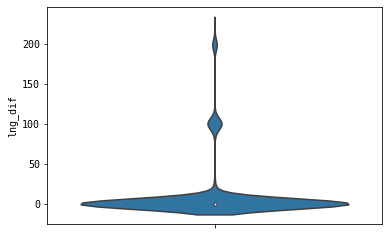

In [68]:
import seaborn as sns
zonas_con_gps = zonas.loc[(zonas.has_gps) & (zonas.id_count > 10)]


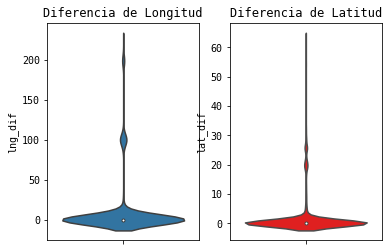

In [78]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
plot_lng = sns.violinplot(zonas_con_gps.lng_dif, orient="v", ax=ax[0])
plot_lng.set_title("Diferencia de Longitud")
plot_lat = sns.violinplot(zonas_con_gps.lat_dif, orient="v", color="red", ax=ax[1])
plot_lat.set_title("Diferencia de Latitud")